# Level4. TF-IDFで文書の分類をする

In [1]:
from datetime import datetime as dt
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### データの取得

ターゲットを以下のカテゴリに絞る

In [2]:
target_categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

データをカテゴリを絞って取得する

In [3]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', categories=target_categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=target_categories)

In [4]:
print(newsgroups_train.target_names == target_categories)
print(newsgroups_test.target_names == target_categories)

True
True


データが同じカテゴリにしたがっていることが確認できた

### データを確認する

In [5]:
print("train data count:", len(newsgroups_train.data))
print(" test data count:", len(newsgroups_test.data))
print("比率:", len(newsgroups_train.data)/len(newsgroups_test.data))

train data count: 11314
 test data count: 7532
比率: 1.5021242697822623


学習データのデータ数は11314個。  
訓練データのデータ数は7532個。  
1.5倍くらい。まぁいい感じ？（train:test = 3:2）

In [6]:
idx = 2
print("="*10, "データ", "="*10)
print(newsgroups_train.data[idx])
print("="*10, "カテゴリ", "="*10)
print(newsgroups_train.target[idx], newsgroups_train.target_names[newsgroups_train.target[idx]])

========== データ ==========
From: twillis@ec.ecn.purdue.edu (Thomas E Willis)
Subject: PB questions...
Organization: Purdue University Engineering Computer Network
Distribution: usa
Lines: 36

well folks, my mac plus finally gave up the ghost this weekend after
starting life as a 512k way back in 1985.  sooo, i'm in the market for a
new machine a bit sooner than i intended to be...

i'm looking into picking up a powerbook 160 or maybe 180 and have a bunch
of questions that (hopefully) somebody can answer:

* does anybody know any dirt on when the next round of powerbook
introductions are expected?  i'd heard the 185c was supposed to make an
appearence "this summer" but haven't heard anymore on it - and since i
don't have access to macleak, i was wondering if anybody out there had
more info...

* has anybody heard rumors about price drops to the powerbook line like the
ones the duo's just went through recently?

* what's the impression of the display on the 180?  i could probably swing
a 

んー、newsgroupってなってるからもっとニュースっぽいのかなと思ったけど、結構難しいな...

> ユーズネット(Usenet)ともいう。電子掲示板に出されたメッセージのこと。各掲示板にはテーマがあり、考えられる限りのトピックに関する何万というニュースグループがある。  
> https://www.weblio.jp/content/newsgroup

なるほど！そもそも俺が考えていたニュースとは違うのかw

## TF-IDFで分類してみる

In [7]:
from nltk.tokenize import wordpunct_tokenize, sent_tokenize

import nltk
import sklearn.feature_extraction.text as fe_text

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('.')   # ピリオドを追加。
stopwords.append(',')   # カンマを追加。
stopwords.append('')

In [9]:
def tokenizer(doc):
    token = []
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    for sent in sent_tokenize(doc):
        for word in wordpunct_tokenize(sent):
            match = re.match(r'[a-z|A-Z]+', word) # 先頭の文字がa-Zでないものは省く
            if match:
                this_word = wnl.lemmatize(word.lower())
                token.append(this_word)
    return token

In [10]:
def bow_tfidf(docs, stopwords, tokenizer):
    '''Bag-of-WordsにTF-IDFで重み調整したベクトルを生成。

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :return: 重み調整したベクトル。
    '''
    vectorizer = fe_text.TfidfVectorizer(norm=None,
                                         stop_words=stopwords,
                                         tokenizer=tokenizer,
                                         analyzer="word")
    vectors = vectorizer.fit_transform(docs)
    return vectors.toarray(), vectorizer

#### 文書をベクトル化する

In [11]:
tf_vectors, tf_vectorizer = bow_tfidf(newsgroups_train.data, stopwords, tokenizer)
print('# BoW + tfidf')
# print(vectorizer.get_feature_names())
print(tf_vectors)
print(tf_vectors.shape)

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# BoW + tfidf
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(11314, 99346)


In [12]:
print(tf_vectorizer.get_feature_names()[:1000])

['a0', 'a000', 'a0000', 'a00l', 'a01', 'a02', 'a03', 'a033', 'a04', 'a043k2', 'a046vyn', 'a0551fv', 'a06s', 'a07', 'a08', 'a0c', 'a0cb', 'a0cbe0e8', 'a0cvydjzs', 'a0g', 'a0h', 'a0j', 'a0k', 'a0k5', 'a0kyo_1t', 'a0l', 'a0m4', 'a0n7', 'a0p3cuh', 'a0rpxo_g', 'a0t', 'a0vmt', 'a0x', 'a0ybtd', 'a0z', 'a1', 'a10', 'a100', 'a1000', 'a10k', 'a118', 'a12', 'a1200', 'a125', 'a13', 'a13001', 'a137490', 'a13x', 'a14', 'a145', 'a14m3', 'a15', 'a160', 'a16pd', 'a17', 'a175u', 'a17r', 'a17u', 'a18', 'a185', 'a186', 'a189', 'a1c', 'a1cc', 'a1e0_s63o', 'a1f', 'a1f0m', 'a1hj', 'a1l', 'a1p1', 'a1r', 'a1rodrig', 'a1rw', 'a1s', 'a1t', 'a1tms1', 'a2', 'a20', 'a2000', 'a203', 'a207706', 'a21', 'a2100', 'a2150', 'a216', 'a21ld', 'a22', 'a23', 'a25', 'a2623', 'a2630', 'a29', 'a2a', 'a2b', 'a2b5z', 'a2br', 'a2d', 'a2dpn', 'a2du6', 'a2fqfx', 'a2i', 'a2jkb', 'a2k', 'a2l', 'a2p', 'a2r89n', 'a2to', 'a2u', 'a2v', 'a2v6', 'a2vmec', 'a2voqx', 'a2vt', 'a2vz0h', 'a2wj', 'a2x', 'a2y', 'a2zgos', 'a3', 'a30', 'a3000', 'a30d

まぁ、これである程度文字列っぽいものに絞れたかな...

#### 作成したした文書ベクトルを学習させ、分類器を作成する

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [14]:
train_X = tf_vectors # 特徴ベクトル
train_Y = newsgroups_train.target # 目的変数
test_X = tf_vectorizer.transform(newsgroups_test.data)
test_Y = newsgroups_test.target

学習

In [15]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_X, train_Y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

推論

In [16]:
pred_Y = clf.predict(test_X)
pred_Y

array([12, 11,  0, ...,  9,  3, 15])

In [17]:
accuracy_score(test_Y, pred_Y)

0.7859798194370685

In [18]:
acc = []
for idx in range(0, 20):
    vec = confusion_matrix(test_Y, pred_Y)[idx]
    acc.append(vec[idx]/sum(vec))

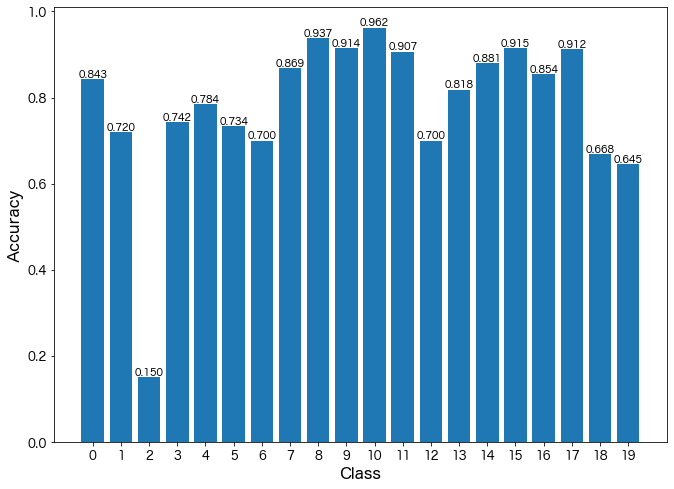

In [19]:
plt.figure(figsize=(11,8))
plt.bar(range(0,20), acc, tick_label=range(0,20))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

for x, y in zip(range(0,20), acc):
    plt.text(x, y, f"{y:.3f}", ha='center', va='bottom')

plt.show()

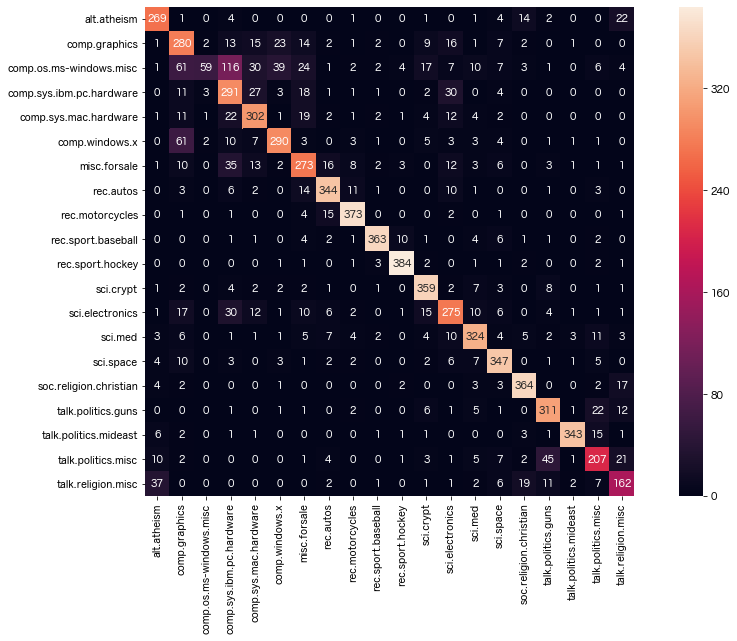

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(confusion_matrix(test_Y, pred_Y),
            xticklabels=target_categories,
            yticklabels=target_categories,
            annot=True, fmt='d', square=True, ax=ax)
ax.set_ylim(20, 0)
plt.show()